# Probabilistic Programming 4: Bayesian filtering & smoothing

#### Goal 
  - Learn how to setup problems for dynamical systems.
  - Learn how to infer states and noise in linear Gaussian state-space model using variational inference.

#### Materials        
  - Mandatory
    - This notebook
    - Lecture notes on dynamical models
  - Optional
    - [Review of latent variable models](https://doi.org/10.1146/annurev-statistics-022513-115657)
    - [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67)
    - [Differences between Julia and Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

Note that none of the material below is new. The point of the Probabilistic Programming sessions is to solve practical problems so that the concepts from Bert's lectures become less abstract.

In [1]:
using Pkg
Pkg.activate("../../../lessons/")
Pkg.instantiate();
IJulia.clear_output();

In [2]:
using JLD
using Statistics
using LinearAlgebra
using Distributions
using RxInfer
using ColorSchemes
using LaTeXStrings
using Plots
default(label="", grid=false, linewidth=3, margin=10Plots.pt)
include("../scripts/clusters.jl");

## Problem: shaking buildings

Suppose you are contacted to estimate how resistant a building is to shaking caused by minor earthquakes. You decide to model the building as a [mass-spring-damper](https://en.wikipedia.org/wiki/Mass-spring-damper_model) system, described by:

$$m \ddot{x} + c\dot{x} + kx = w \, ,$$

where $m$ corresponds to the mass of the building, $c$ is friction and $k$ the stiffness of the building's main supports. You don't know the external force acting upon the building and decide to model it as white noise $w$. In essence, this means you think the building will be pushed to the left as strongly on average as it will be pushed to the right. A simple discretization scheme with substituted variable $z = [x \ \dot{x}]$ and time-step $\Delta t$ yields:

$$z_{k} = \underbrace{\begin{bmatrix} 1 & \Delta t \\ \frac{-k}{m}\Delta t & \frac{-c}{m}\Delta t + 1 \end{bmatrix}}_{A} z_{k-1} + q_k \, ,$$

where $q_k \sim \mathcal{N}(0, Q)$ with covariance matrix $Q$. 

You place a series of sensors on the building that measure the displacement:

$$ y_k = \underbrace{\begin{bmatrix} 1 & 0 \end{bmatrix}}_{C} z_k + r_k \, $$

where the measurement noise is white as well: $r_k \sim \mathcal{N}(0, \sigma^2)$. You have a good estimate of the variance $\sigma^2$ from previous sensor calibrations and decide to consider it a known variable.

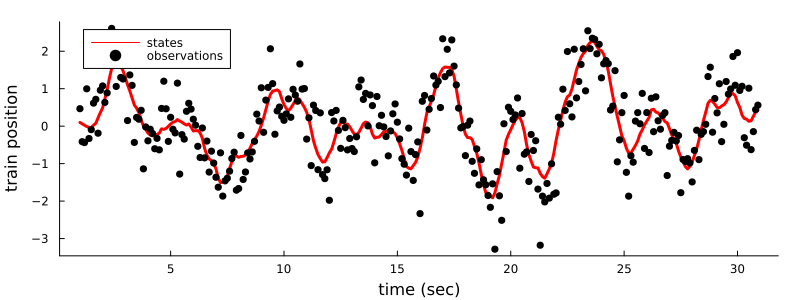

In [12]:
# Load data from file
data = load("../datasets/shaking_buildings.jld")

# Data
states = data["states"]
observations = data["observations"]

# Parameters
mass = data["m"]
friction = data["c"]
stiffness = data["k"]

# Measurement noise variance
σ = data["σ"]

# Time
Δt = data["Δt"]
T = length(observations)
time = range(1,step=Δt,length=T)

plot(time, states[1,:], color="red", label="states", xlabel="time (sec)", ylabel="train position")
scatter!(time, observations, color="black", label="observations", legend=:topleft, size=(800,300))

### Model specification

Following the steps from the [lecture on Dynamic Systems](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Dynamic-Models.ipynb), we can derive the following probabilistic state-space model:

$$\begin{aligned} p(z_k \mid z_{k-1}) =&\ \mathcal{N}(z_k \mid A z_{k-1}, Q)\\ p(y_k \mid z_k) =&\ \mathcal{N}(y_k \mid C z_k, \sigma^2) \, . \end{aligned}$$

For now, we will use a simple structure for the process noise covariance matrix, e.g. $Q = I$. If we consider a Gaussian prior distribution for the initial state

$$ p(z_0) = \mathcal{N}(m_0, S_0) \, ,$$

we obtain a complete generative model:

$$\begin{aligned} \underbrace{p(y_{1:T}, z_{0:T})}_{\text{generative model}} = \underbrace{p(z_0)}_{\text{prior}} \, \prod_{k=1}^T \, \underbrace{p(y_k \mid z_k)}_{\text{likelihood}} \, \underbrace{p(z_k \mid z_{k-1})}_{\text{state transition}} \end{aligned}$$

To define this model in RxInfer, we must start with the process matrices:

In [13]:
# Transition matrix
A = [1 Δt; -stiffness/mass*Δt -friction/mass*Δt+1]

# Emission matrix
C = [1.0, 0.0]

# Set process noise covariance matrix
Q = diagm(ones(2))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

Next, we define a linear Gaussian dynamical system with only the states as unknown variables:

In [14]:
@model function LGDS(prior_params, A,C,Q, σ; T=1)
    "State estimation in linear Gaussian dynamical system"
    
    z = randomvar(T)
    y = datavar(Float64,T)
    
    # Prior state
    z_0 ~ MvNormalMeanCovariance(prior_params[:z0][1], prior_params[:z0][2])
    
    z_kmin1 = z_0
    for k in 1:T
        
        # State transition
        z[k] ~ MvNormalMeanCovariance(A * z_kmin1, Q)
        
        # Likelihood
        y[k] ~ NormalMeanVariance(dot(C, z[k]), σ^2)
        
        # Update recursive aux
        z_kmin1 = z[k]
        
    end
    return y, z
end

# Initial state prior
prior_params = Dict(:z0 => (zeros(2), diageye(2)))

(posteriors,_) = inference(
    model       = LGDS(prior_params, A,C,Q, σ, T=T),
    data        = (y = [observations[k] for k in 1:T],),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (z_0, z)
  Free Energy:     | Real[434.098]


Let's extract the inferred states and visualize them.

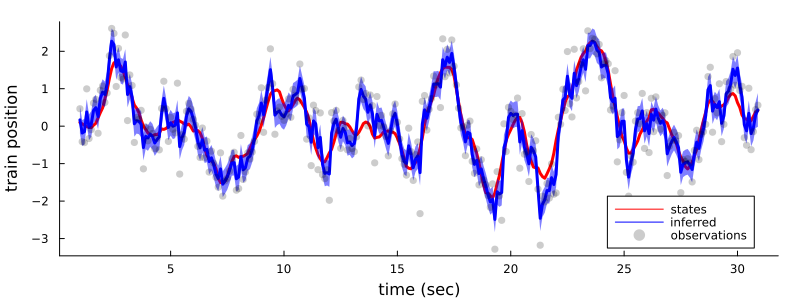

In [15]:
m_z = cat(mean.(posteriors[:z])...,dims=2)
v_z = cat(var.( posteriors[:z])...,dims=2)

plot(time, states[1,:], color="red", label="states", xlabel="time (sec)", ylabel="train position")
plot!(time, m_z[1,:], color="blue", ribbon=v_z[1,:], label="inferred")
scatter!(time, observations, color="black", alpha=0.2, label="observations", legend=:bottomright, size=(800,300))

Mmmh... the inferred states are not smooth at all. This is most likely due to our process noise covariance matrix not being calibrated. So can we improve? 

---

Of course, as Bayesians, we can just treat $Q$ as an unknown random variable and infer its posterior distribution. Adjusting the model is straightforward. The probabilistic state-space model becomes:

$$\begin{aligned} p(z_k \mid z_{k-1},Q) =&\ \mathcal{N}(z_k \mid A z_{k-1}, Q)\\ p(y_k \mid z_k) =&\ \mathcal{N}(y_k \mid C z_k, \sigma^2) \, , \end{aligned}$$

with priors

$$\begin{aligned} p(Q) =&\ \mathcal{W}^{-1}(\nu, \Lambda) \\ p(z_0) =&\ \mathcal{N}(m_0, S_0) \, . \end{aligned}$$

The $\mathcal{W}^{-1}$ represents an inverse-Wishart distribution with degrees-of-freedom $\nu$ and scale matrix $\Lambda$. This will give the following generative model:

$$\begin{aligned} \underbrace{p(y_{1:T}, z_{0:T}, Q)}_{\text{generative model}} = \underbrace{p(z_0)p(Q)}_{\text{priors}} \, \prod_{k=1}^T \, \underbrace{p(y_k \mid z_k)}_{\text{likelihood}} \, \underbrace{p(z_k \mid z_{k-1},Q)}_{\text{state transition}}
\end{aligned}$$

Our model definition in ReactiveMP is only slightly larger:

In [16]:
@model function LGDS_Q(prior_params, A,C, σ; T=1)
    "State estimation in a linear Gaussian dynamical system with unknown process noise"
    
    z = randomvar(T)
    y = datavar(Float64,T)
    
    # Prior state
    z_0 ~ MvNormalMeanCovariance(prior_params[:z0][1], prior_params[:z0][2])
    
    # Process noise covariance matrix
    Q ~ InverseWishart(prior_params[:Q][1], prior_params[:Q][2])
    
    z_kmin1 = z_0
    for k in 1:T
        
        # State transition
        z[k] ~ MvNormalMeanCovariance(A * z_kmin1, Q)
        
        # Likelihood
        y[k] ~ NormalMeanVariance(dot(C, z[k]), σ^2)
        
        # Update recursive aux
        z_kmin1 = z[k]
        
    end
    return y, z, Q
end

---

#### Exercise

Think of what might be appropriate prior parameters for the Inverse-Wishart distribution. Should its mean be high or low here?

---

I have chosen the following set of prior parameters:

In [17]:
# Define prior parameters
prior_params = Dict(:z0 => (zeros(2), diageye(2)),
                    :Q  => (10, diageye(2)))

Dict{Symbol, Tuple{Any, Matrix{Float64}}} with 2 entries:
  :Q  => (10, [1.0 0.0; 0.0 1.0])
  :z0 => ([0.0, 0.0], [1.0 0.0; 0.0 1.0])

The variational inference procedure for estimating states and the process noise covariance matrix simultaneously requires a bit more thought, but is still very straightforward:

In [18]:
# Iterations of variational inference
num_iters = 100

# Initialize variational marginal distributions and messages
inits = Dict(:z => MvNormalMeanCovariance(zeros(2), diageye(2)),
             :Q => InverseWishart(10, diageye(2)))

# Define variational distribution factorization
constraints = @constraints begin
    q(z_0, z,Q) = q(z_0, z)q(Q)
end

# Variational inference procedure
results = inference(
    model         = LGDS_Q(prior_params, A,C, σ, T=T),
    data          = (y = [observations[k] for k in 1:T],),
    constraints   = constraints,
    iterations    = num_iters,
    options       = (limit_stack_depth = 100,),
    initmarginals = inits,
    initmessages  = inits,
    free_energy   = true,
    showprogress  = true,
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Inference results:
  Posteriors       | available for (z_0, Q, z)
  Free Energy:     | Real[425.591, 368.392, 359.522, 356.68, 356.422, 356.522, 356.717, 356.87, 356.851, 356.897  …  357.077, 357.078, 357.078, 357.078, 357.079, 357.079, 357.079, 357.08, 357.08, 357.08]


Again, let's inspect the free energy to see if we have converged.

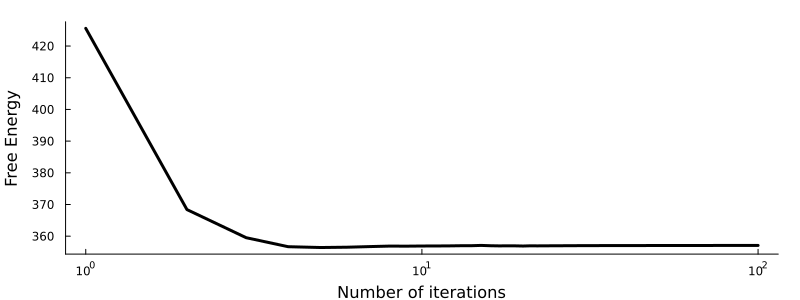

In [19]:
plot(1:num_iters, 
     results.free_energy, 
     color="black", 
     xscale=:log10,
     xlabel="Number of iterations", 
     ylabel="Free Energy", 
     size=(800,300))

Alright. That looks good. Let's extract the inferred states and visualize.

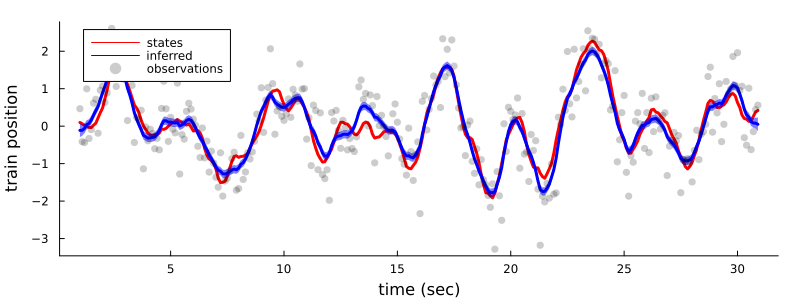

In [20]:
m_z = cat(mean.(last(results.posteriors[:z]))...,dims=2)
v_z = cat(var.(last(results.posteriors[:z]))...,dims=2)

plot(time, states[1,:], color="red", label="states", xlabel="time (sec)", ylabel="train position")
plot!(time, m_z[1,:], color="blue", ribbon=v_z[1,:], label="inferred")
scatter!(time, observations, color="black", alpha=0.2, label="observations", legend=:topleft, size=(800,300))

That's much smoother. The free energy of this model ($\mathcal{F} = 357.08$) is smaller than that of the earlier model with $Q$ set to an identity matrix ($\mathcal{F} = 434.10$). That means that the added cost of inferring the matrix $Q$ is offset by the increase in performance it provides. 

The error with respect to the true states seems smaller as well, but in practice we of course can't check this.

Let's inspect the inferred process noise covariance matrix:

In [21]:
Q_MAP = mean(last(results.posteriors[:Q]))

2×2 Matrix{Float64}:
 0.0600678   0.00535827
 0.00535827  0.145712

We do not have enough data to recover the true process noise covariance matrix exactly, but the result is definitely closer to the truth.

In [22]:
# True data
Q_true = data["Q"]

2×2 Matrix{Float64}:
 0.00173611  0.0240885
 0.0240885   0.549072

Let's visualize that for a closer look:

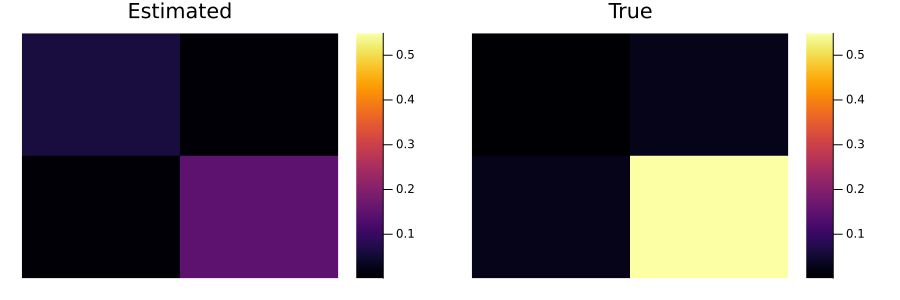

In [23]:
# Colorbar limits
clims = (minimum([Q_MAP[:]; Q_true[:]]), maximum([Q_MAP[:]; Q_true[:]]))
 
# Plot covariance matrices as heatmaps
p401 = heatmap(Q_MAP, axis=([], false), yflip=true, title="Estimated", clims=clims)
p402 = heatmap(Q_true, axis=([], false), yflip=true, title="True", clims=clims)
plot(p401,p402, layout=(1,2), size=(900,300))

---

#### Exercise

Can you come up with a way to improve the model even further?

---